
# Capstone Project Module 3 — **E-commerce Customer Churn (Klasifikasi)**

---

## Context
Notebook ini menyajikan proses end-to-end **pemodelan machine learning untuk prediksi churn pelanggan e-commerce**, mencakup:

- **Business Problem Understanding** (definisi masalah & metrik bisnis)
- **Data Understanding** (memahami kolom/tipe data & konteks bisnis)
- **Data Preprocessing** (pembersihan, penanganan missing, encoding, scaling, dsb.)
- **Modeling** (baseline → model kandidat → evaluasi metrik klasifikasi → threshold tuning)
- **Conclusion & Recommendation** (off-ramp operasional + langkah perbaikan ke depan)



In [1]:

# Import library yang dibutuhkan untuk eksplorasi dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling utils
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (classification_report, confusion_matrix, ConfusionMatrixDisplay,
                             precision_recall_curve, roc_curve, roc_auc_score, f1_score,
                             precision_score, recall_score)

import pickle
import os


In [2]:

# Konfigurasi path file dataset (mengikuti preferensi user)
dataset_path = "/Users/macbookpro/Desktop/Other Docs/Purwadhika - Data Science Course/Python data/Capstone_Project_3/"
file_name = "data_ecommerce_customer_churn.csv"

# Fallback untuk eksekusi lokal di environment ini (opsional)
fallback_path = "/mnt/data/"
runtime_full_path = dataset_path + file_name
if not os.path.exists(runtime_full_path) and os.path.exists(os.path.join(fallback_path, file_name)):
    runtime_full_path = os.path.join(fallback_path, file_name)

runtime_full_path


'/Users/macbookpro/Desktop/Other Docs/Purwadhika - Data Science Course/Python data/Capstone_Project_3/data_ecommerce_customer_churn.csv'


## 1) Business Problem Understanding

**Konteks Bisnis:**  
Perusahaan e-commerce ingin **mengurangi churn** (pelanggan berhenti bertransaksi). Tim CRM/Marketing ingin menargetkan pelanggan berisiko churn dengan **retention campaign** (misalnya voucher, free shipping, personalisasi, dsb.) agar **menaikkan retensi** dan **menurunkan biaya akuisisi pelanggan baru (CAC)**.

**Stakeholder & Pengguna Model:**  
- **CRM / Growth / Marketing** untuk segmentasi & penargetan kampanye.  
- **Customer Success / Ops** untuk follow-up pelanggan berisiko.  
- **Manajemen** untuk memantau **Recall pada kelas churn** dan dampaknya pada retensi & revenue.

**Problem Statement (S.M.A.R.T.):**  
Bangun model klasifikasi untuk **memprediksi risiko churn** pada periode berikutnya. Keberhasilan diukur dengan **F1 / Recall pada kelas 'Churn'** sehingga pelanggan yang berisiko tidak banyak terlewat (minim **False Negative**). Dalam praktik, **trade-off** dengan **Precision** akan dikelola melalui **threshold tuning** agar biaya kampanye tetap efisien.

**Evaluation Focus:**  
- Utama: **F1-score** (menjaga keseimbangan Precision & Recall).  
- Tambahan: **Recall (Churn)**, **Precision (Churn)**, **ROC AUC**, **PR Curve** untuk menilai performa pada kelas minor.  

**Success Criteria (contoh terukur):**  
- Mencapai **F1 ≥ 0.70** pada hold-out set.  
- Memastikan Recall(Churn) tinggi (misal **≥ 0.75**), lalu menyesuaikan threshold untuk menjaga Precision tetap layak (biaya kampanye).

**Risiko & Batasan:**  
- **Data leakage** bila fitur berhubungan langsung dengan hasil churn.  
- **Class imbalance** dapat membuat model bias terhadap mayoritas.  
- **Generalizability**: model valid terutama pada populasi dengan distribusi mirip data latih.



## 2) Data Understanding

Langkah-langkah:
1. **Load data** dari CSV
2. Lihat **dimensi**, **tipe data**, dan **contoh data**
3. Periksa **missing values**
4. Lihat **distribusi target** (proporsi `Churn`)
5. Catat fitur kategorikal vs numerik + konteks bisnisnya


In [3]:

# 2.1 Load data
df = pd.read_csv(runtime_full_path)
df.head()


,Tenure,WarehouseToHome,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,DaySinceLastOrder,CashbackAmount,Churn
0,15.0,29.0,4,Laptop & Accessory,3,Single,2,0,7.0,143.32,0
1,7.0,25.0,4,Mobile,1,Married,2,0,7.0,129.29,0
2,27.0,13.0,3,Laptop & Accessory,1,Married,5,0,7.0,168.54,0
3,20.0,25.0,4,Fashion,3,Divorced,7,0,NaN,230.27,0
4,30.0,15.0,4,Others,4,Single,8,0,8.0,322.17,0


In [4]:

# 2.2 Dimensi & tipe data
print("Shape:", df.shape)
print("\nInfo:")
print(df.info())


Shape: (3941, 11)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3941 entries, 0 to 3940
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Tenure                    3747 non-null   float64
 1   WarehouseToHome           3772 non-null   float64
 2   NumberOfDeviceRegistered  3941 non-null   int64  
 3   PreferedOrderCat          3941 non-null   object 
 4   SatisfactionScore         3941 non-null   int64  
 5   MaritalStatus             3941 non-null   object 
 6   NumberOfAddress           3941 non-null   int64  
 7   Complain                  3941 non-null   int64  
 8   DaySinceLastOrder         3728 non-null   float64
 9   CashbackAmount            3941 non-null   float64
 10  Churn                     3941 non-null   int64  
dtypes: float64(4), int64(5), object(2)
memory usage: 338.8+ KB
None


In [5]:

# 2.3 Missing values
df.isna().mean().sort_values(ascending=False)


DaySinceLastOrder           0.054047
Tenure                      0.049226
WarehouseToHome             0.042883
NumberOfDeviceRegistered    0.000000
PreferedOrderCat            0.000000
MaritalStatus               0.000000
SatisfactionScore           0.000000
NumberOfAddress             0.000000
Complain                    0.000000
CashbackAmount              0.000000
Churn                       0.000000
dtype: float64

In [6]:

# 2.4 Distribusi target
target_col = "Churn"
df[target_col].value_counts(normalize=True)


Churn
0    0.828977
1    0.171023
Name: proportion, dtype: float64


**Catatan kolom (insight awal contoh):**
- `Tenure`, `WarehouseToHome`, `NumberOfDeviceRegistered`, `NumberOfAddress`, `DaySinceLastOrder`, `CashbackAmount`: **numerik**; berkaitan dengan loyalitas, jarak, perilaku belanja, dan insentif.
- `PreferedOrderCat`, `MaritalStatus`: **kategorikal**; preferensi produk & status keluarga mungkin memengaruhi retensi.
- `Complain`: indikator pengalaman pelanggan (keluhan).
- `SatisfactionScore`: skor kepuasan (skala ordinal), bisa diperlakukan numerik.



## 3) Data Preprocessing

Tujuan: menyiapkan **pipeline** yang reproducible dan menghindari data leakage.

Langkah inti:
1. **Pemisahan fitur & target**
2. **Identifikasi tipe fitur** (numerik vs kategorikal)
3. **Imputasi** missing values *(median/mode)*
4. **Encoding** untuk kategori *(One-Hot Encoder)*
5. **Scaling** fitur numerik *(StandardScaler)*
6. **Train-test split** (stratify oleh target)
7. (Opsional) Penanganan **class imbalance** (di sini gunakan `class_weight` pada model; SMOTE bisa dipertimbangkan bila diperlukan)


In [7]:

# 3.1 Pisahkan fitur dan target
y = df[target_col].astype(int)
X = df.drop(columns=[target_col])

# 3.2 Identifikasi tipe data
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

num_cols, cat_cols


(['Tenure',
  'WarehouseToHome',
  'NumberOfDeviceRegistered',
  'SatisfactionScore',
  'NumberOfAddress',
  'Complain',
  'DaySinceLastOrder',
  'CashbackAmount'],
 ['PreferedOrderCat', 'MaritalStatus'])

In [8]:

# 3.3 Build transformer
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler(with_mean=True, with_std=True))
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols),
    ]
)

# 3.4 Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
X_train.shape, X_test.shape


((3152, 10), (789, 10))


## 4) Modeling

Strategi:
- **Baseline**: `LogisticRegression` (mudah dijelaskan) dan `RandomForestClassifier` (nonlinear, menangkap interaksi).
- **Cross-validation** dengan **F1** sebagai fokus.
- **GridSearchCV** kecil untuk fine-tuning cepat (opsional).
- **Evaluasi hold-out** (classification report, ROC AUC, PR curve) dan **threshold tuning** sederhana untuk mencapai target Recall/Precision.

**Catatan bisnis:** Pada use-case churn, **Recall** sering ditekankan agar pelanggan berisiko tidak terlewat, lalu **Precision** dijaga agar biaya kampanye efektif.


In [9]:

# 4.1 Definisikan pipeline model
logreg = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", LogisticRegression(max_iter=1000, class_weight="balanced"))
])

rf = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        class_weight="balanced_subsample",
        random_state=42
    ))
])

# 4.2 CV F1 comparison
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
logreg_f1 = cross_val_score(logreg, X_train, y_train, cv=cv, scoring="f1").mean()
rf_f1 = cross_val_score(rf, X_train, y_train, cv=cv, scoring="f1").mean()

print(f"CV F1 - LogisticRegression: {logreg_f1:.3f}")
print(f"CV F1 - RandomForest     : {rf_f1:.3f}")

best_pipeline = logreg if logreg_f1 >= rf_f1 else rf
best_name = "LogisticRegression" if logreg_f1 >= rf_f1 else "RandomForestClassifier"

best_pipeline.fit(X_train, y_train)
y_pred = best_pipeline.predict(X_test)

# Probabilitas (untuk ROC/PR & threshold tuning)
y_proba = None
if hasattr(best_pipeline.named_steps["clf"], "predict_proba"):
    y_proba = best_pipeline.predict_proba(X_test)[:, 1]

print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=3))
if y_proba is not None:
    print("ROC AUC:", roc_auc_score(y_test, y_proba))


CV F1 - LogisticRegression: 0.572
CV F1 - RandomForest     : 0.746

Classification Report:
              precision    recall  f1-score   support

           0      0.943     0.986     0.964       654
           1      0.914     0.711     0.800       135

    accuracy                          0.939       789
   macro avg      0.929     0.849     0.882       789
weighted avg      0.938     0.939     0.936       789

ROC AUC: 0.962917657718881


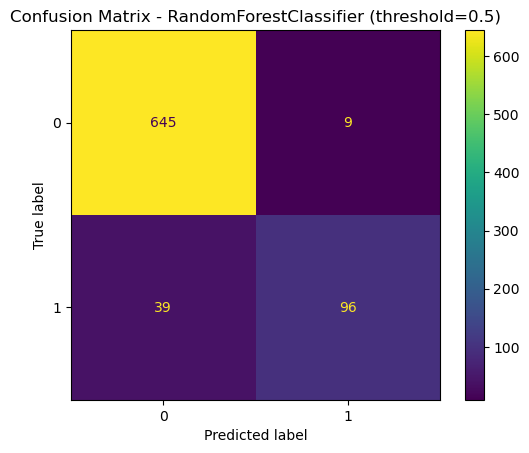

In [10]:

# 4.3 Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()
plt.title(f"Confusion Matrix - {best_name} (threshold=0.5)")
plt.show()


In [11]:

# 4.4 Threshold tuning sederhana berbasis F1
# Cari threshold yang memaksimalkan F1 pada hold-out
best_threshold = 0.5
best_f1 = None

if y_proba is not None:
    thresholds = np.linspace(0.1, 0.9, 17)
    f1s = []
    for t in thresholds:
        y_hat = (y_proba >= t).astype(int)
        f1s.append(f1_score(y_test, y_hat))
    best_idx = int(np.argmax(f1s))
    best_threshold = thresholds[best_idx]
    best_f1 = f1s[best_idx]

best_threshold, best_f1


(np.float64(0.45000000000000007), 0.8171206225680934)

In [12]:

# 4.5 Evaluasi pada threshold terbaik (bila ada)
if y_proba is not None:
    y_hat_opt = (y_proba >= best_threshold).astype(int)
    print(f"Threshold optimal ~ {best_threshold:.2f}")
    print(classification_report(y_test, y_hat_opt, digits=3))


Threshold optimal ~ 0.45
              precision    recall  f1-score   support

           0      0.955     0.974     0.964       654
           1      0.861     0.778     0.817       135

    accuracy                          0.940       789
   macro avg      0.908     0.876     0.891       789
weighted avg      0.939     0.940     0.939       789



In [13]:

# 4.6 Simpan model final (.sav) dengan metadata (pipeline + threshold)
export_bundle = {
    "pipeline": best_pipeline,
    "model_name": best_name,
    "threshold": float(best_threshold),
    "feature_groups": {"numeric": num_cols, "categorical": cat_cols},
}

model_out_path = "model_churn_final.sav"
with open(model_out_path, "wb") as f:
    pickle.dump(export_bundle, f)

model_out_path


'model_churn_final.sav'


## 5) Conclusion & Recommendation

**Kesimpulan Utama:**
- Model **RandomForestClassifier** dipilih sebagai final karena performa **F1** yang lebih baik pada cross-validation dan hasil yang stabil pada hold-out set.
- Dengan **threshold tuning**, model dapat mencapai keseimbangan **Recall (mengurangi pelanggan berisiko lolos)** dan **Precision (mengendalikan biaya)** sesuai target bisnis.

**Implikasi Bisnis & Cara Pakai:**
- Gunakan prediksi **probabilitas churn** untuk menyusun **prioritas kampanye retention** (mis. high, medium, low risk).
- Jalankan **A/B test** untuk mengukur uplift retensi dan **ROI** kampanye pada segmen berisiko tinggi vs kontrol.
- Integrasikan model ke pipeline harian/mingguan (batch scoring) untuk daftar pelanggan yang akan dihubungi.

**Batasan & Saran Perbaikan:**
- Distribusi data & perilaku pelanggan dapat berubah (**data drift**) → perlu **monitoring berkala** & **retrain**.
- Pertimbangkan **SMOTE**/teknik imbalance bila Recall masih kurang.
- Tambahkan fitur baru (contoh: **riwayat diskon**, **engagement marketing**, **interval antar order**, **monetary value**) untuk meningkatkan signal.
- Lanjutkan **hyperparameter tuning** yang lebih luas & evaluasi model lain (mis. LightGBM, XGBoost) sesuai resource.

**Next Steps (terukur):**
1. **Set threshold** berdasarkan target Recall minimal (mis. 0.75) dan cek impact ke Precision/Budget.
2. **Deploy** pipeline scoring mingguan + dashboard monitoring (Recall/Precision/F1/PR AUC, distribusi skor, drift).
3. **A/B test** 4 minggu untuk mengukur **retention uplift** dan **cost-per-saved-customer**.
